In [473]:
%matplotlib inline
import matplotlib
# matplotlib.use('Agg')  # Use non-interactive backend
import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
import networkx as nx
import matplotlib.pyplot as plt
from typing import Dict, Any, List

## Creating a custom network


In [474]:
network_type = "small_world"
seed = 47

hidden_size = 64
k = 8 # k ≪ n
p = 0.1 # p ≈ 0.1
rng = np.random.RandomState(seed)


batch_size = 32              # PPO batch size
learning_rate = 0.01       # PPO learning rate (paper-aligned)
gamma = 0.99                 # PPO gamma
gae_lambda = 0.95            # PPO GAE lambda
clip_range = 0.2            # PPO clip range
ent_coef = 0.01             # PPO entropy coefficient
max_grad_norm = 0.5          # PPO max gradient norm

In [475]:
"""
make_env
"""
# Initialize iteration rewards collection (like baseline MLP)
iteration_rewards = []

env_name = "CartPole-v1"
env = gym.make(env_name)

# Seed action and observation spaces
env.reset(seed=seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)

47

In [476]:
"""Create topology network based on type and parameters."""
# 1. Define input/output nodes (task-specific, no fallbacks) - FIRST
try:
    from stable_baselines3.common.preprocessing import get_flattened_obs_dim
    # Observation dim - use actual observation space
    if env.observation_space is not None:
        input_dim = int(get_flattened_obs_dim(env.observation_space))
    else:
        raise ValueError("Observation space not available - cannot create network")
    

    # Action dim - use actual action space
    if env.action_space is not None:
        action_space = env.action_space
        if hasattr(action_space, 'n'):
            output_dim = int(action_space.n)
        elif hasattr(action_space, 'shape') and len(action_space.shape) > 0:
            output_dim = int(action_space.shape[0])
        else:
            raise ValueError("Action space not properly configured - cannot create network")
    else:
        raise ValueError("Action space not available - cannot create network")
        
except Exception as e:
    # No fallbacks - fail explicitly if we can't determine dimensions
    raise ValueError(f"Cannot determine network dimensions: {e}")


input_dim, output_dim

(4, 2)

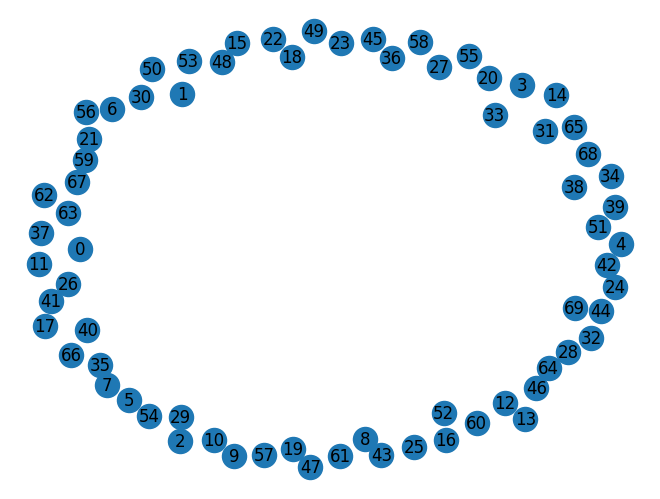

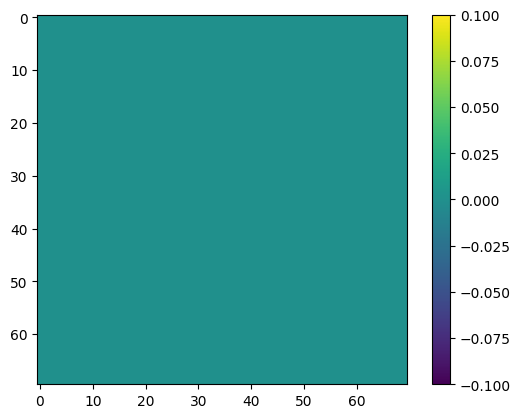

In [477]:
# Create small world topology object
"""
Generate the small-world network topology as a single connected graph.

Args:
    num_layers: Number of layers (ignored for small world)
    input_dim: Number of input nodes (if provided, extends graph)
    output_dim: Number of output nodes (if provided, extends graph)
"""
# Calculate total nodes needed
total_nodes = input_dim + hidden_size + output_dim


G = nx.DiGraph()
G.add_nodes_from(range(total_nodes))

# visualise the nx graph node by node
nx.draw(G, with_labels=True)
plt.show()

# output connecitivity matrix plot
plt.imshow(nx.to_numpy_array(G))
plt.colorbar()
plt.show()



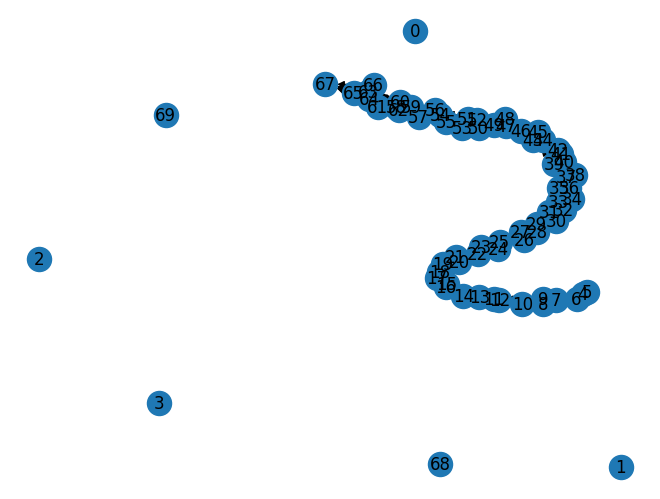

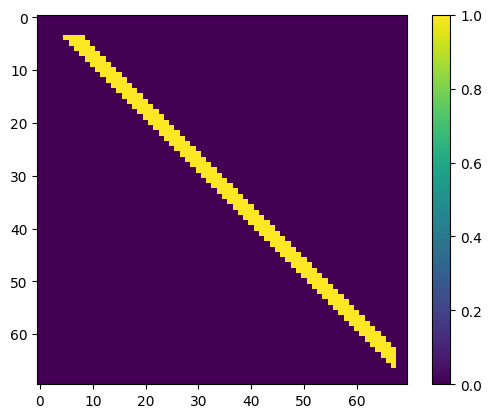

In [478]:
# Create small-world connections only among hidden nodes

hidden_start = input_dim
hidden_end = hidden_start + hidden_size

# Create initial ring lattice structure for hidden nodes (directed, acyclic)
for i in range(hidden_start, hidden_end):
    # Only add edges to higher-indexed hidden nodes to maintain acyclicity
    for j in range(1, k // 2 + 1):
        target = hidden_start + ((i - hidden_start + j) % hidden_size)
        if target > i and target < hidden_end:  # Only add forward edges within hidden layer
            G.add_edge(i, target)


# visualise the nx graph node by node
nx.draw(G, with_labels=True)
plt.show()

# output connecitivity matrix plot
plt.imshow(nx.to_numpy_array(G))
plt.colorbar()
plt.show()

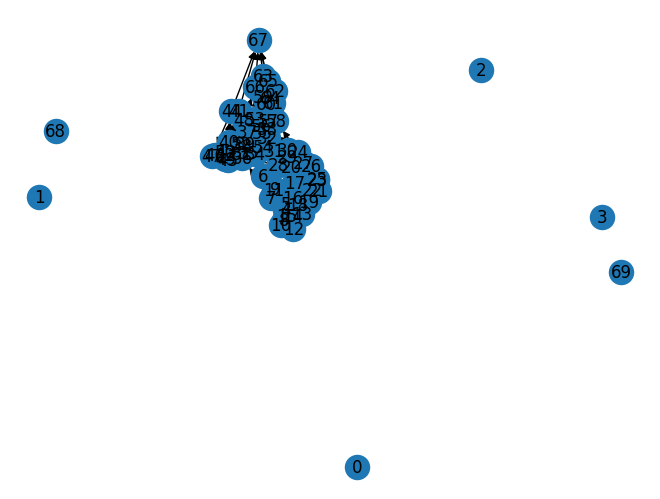

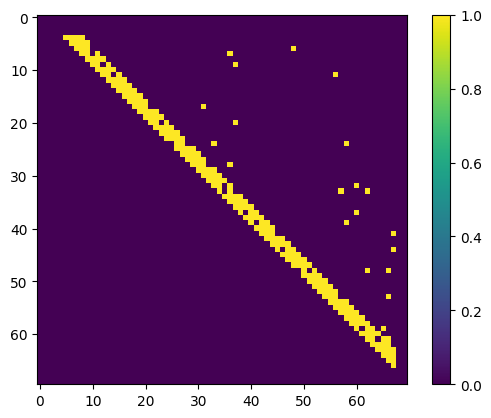

In [479]:
# Rewire edges with probability p (maintaining acyclicity)

for edge in list(G.edges()):
    if rng.random() < p:
        # Remove the edge
        G.remove_edge(*edge)
        # Add a new random edge (only to higher-indexed hidden nodes)
        new_node = rng.randint(edge[0] + 1, hidden_end)
        while G.has_edge(edge[0], new_node):
            new_node = rng.randint(edge[0] + 1, hidden_end)
        G.add_edge(edge[0], new_node)

# visualise the nx graph node by node
nx.draw(G, with_labels=True)
plt.show()

# output connecitivity matrix plot
plt.imshow(nx.to_numpy_array(G))
plt.colorbar()
plt.show()


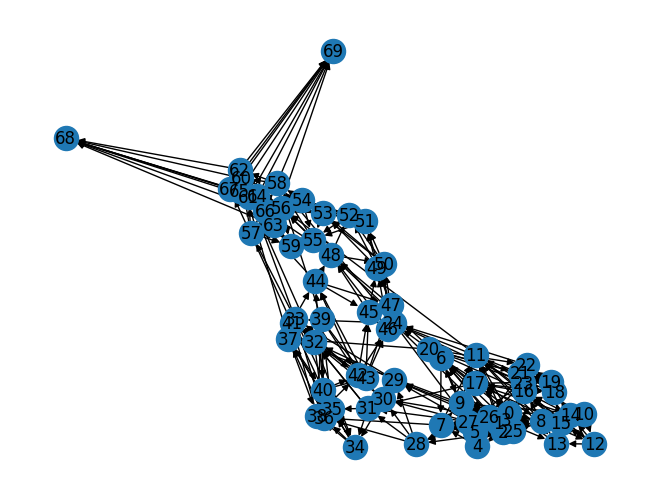

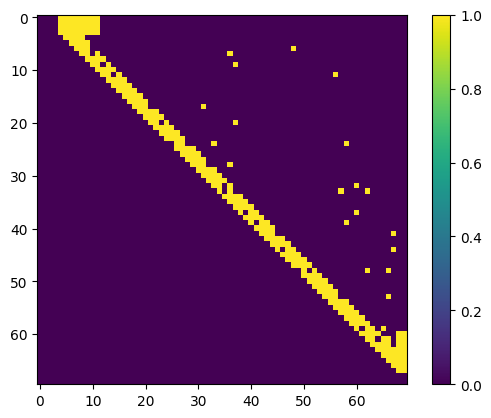

In [480]:
# Add connections from input nodes to hidden nodes


if input_dim is not None:
    for input_node in range(input_dim):
        for hidden_node in range(hidden_start, hidden_start + min(k, hidden_size)):
            G.add_edge(input_node, hidden_node)

# Add connections from hidden nodes to output nodes
if output_dim is not None:
    for output_node in range(hidden_end, total_nodes):
        for hidden_node in range(hidden_end - min(k, hidden_size), hidden_end):
            G.add_edge(hidden_node, output_node)

# visualise the nx graph node by node
nx.draw(G, with_labels=True)
plt.show()

# output connecitivity matrix plot
plt.imshow(nx.to_numpy_array(G))
plt.colorbar()
plt.show()

In [481]:
# Create FeedForwardNetwork from topology graph

topology = G
input_nodes = list(range(input_dim))
output_nodes = list(range(input_dim + hidden_size, input_dim + hidden_size + output_dim))

network_params = {'learning_rate': 0.001, 'activation': 'tanh'}

# Store original topology for metrics
original_topology = topology

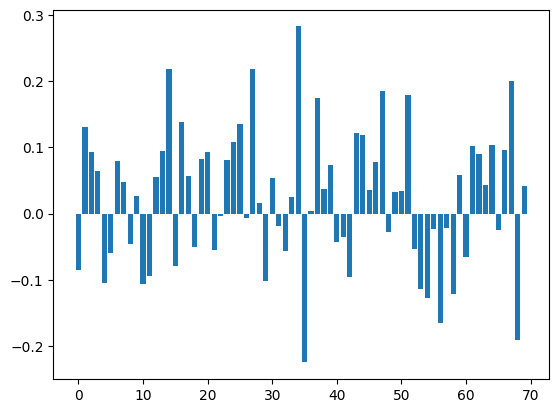

In [482]:
# Initialize node states for FFN

# Set seed for reproducible weight initialization
np.random.seed(seed)

node_states = {}
for node in list(topology.nodes()):
    # Only initialize weights for incoming edges (predecessors)
    node_states[node] = {
        'activation': 0.0,
        'bias': np.random.normal(0, 0.1),
        'weights': {
            neighbor: np.random.normal(0, 0.1)
            for neighbor in topology.predecessors(node)
        }
    }

# visualize node biases in a plot
plt.bar(node_states.keys(), [state['bias'] for state in node_states.values()])
plt.show()



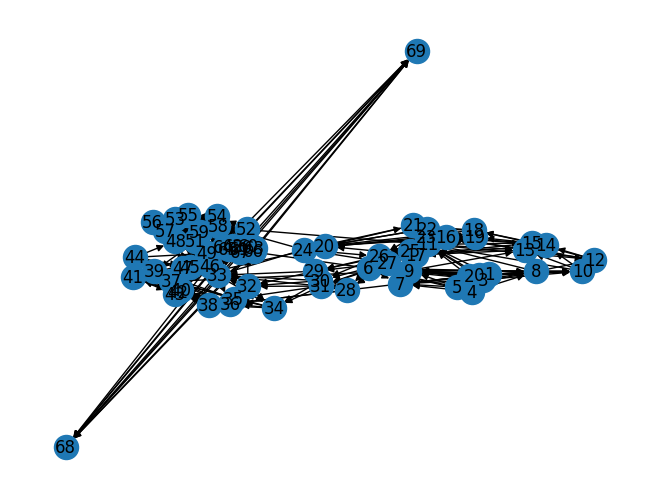

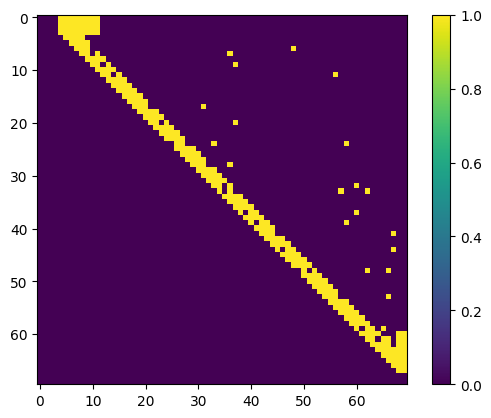

In [483]:
# Validation

# Track active edges for runtime validation
active_edges = set()

# Store allowed edges from topology for validation
allowed_edges = set(topology.edges())

# Ensure topology is a DAG
if not nx.is_directed_acyclic_graph(topology):
    raise ValueError("FFN requires a Directed Acyclic Graph (DAG) topology")

# Store node ordering for forward pass
node_order = list(nx.topological_sort(topology))

# visualise the nx graph node by node
nx.draw(pruned_topology, with_labels=True)
plt.show()

# output connecitivity matrix plot
plt.imshow(nx.to_numpy_array(G))
plt.colorbar()
plt.show()


## Training

In [ ]:
# Forward pass through FFN

def forward(self, inputs: Dict[int, Any]) -> Dict[int, Any]:
    """Process inputs through the FFN.
    
    Args:
        inputs: Dictionary mapping input node indices to their input values
        
    Returns:
        Dictionary mapping output node indices to their output values
    """
    # Clear active edges at start of forward pass
    self._clear_active_edges()
    
    # Initialize activations with tensors
    # Get batch size from first input tensor
    first_input = next(iter(inputs.values()))
    if torch.is_tensor(first_input):
        batch_size = first_input.shape[0]
        device = first_input.device
    else:
        batch_size = 1
        device = torch.device('cpu')
    
    activations = {node: torch.zeros(batch_size, device=device) for node in list(self.topology.nodes())}
    
    # Set input node activations
    for node, value in inputs.items():
        if node in self.input_nodes:
            activations[node] = value
    
    # Process through network in topological order
    for layer in self._node_order:
        if layer not in self.input_nodes:
            # Get active predecessors
            active_predecessors = [
                neighbor for neighbor in self.topology.predecessors(layer)
                if torch.any(activations[neighbor] != 0)
            ]
            
            # Update active edges
            self._update_active_edges(layer, active_predecessors)
            
            # Validate runtime edges
            is_valid, error_msg = self._validate_runtime_edges()
            if not is_valid:
                raise ValueError(f"Runtime topology violation: {error_msg}")
            
            # Sum weighted inputs from predecessors
            bias = self.node_states[layer]['bias']
            weighted_sum = torch.full((batch_size,), bias, dtype=torch.float32, device=device)
            for neighbor in self.topology.predecessors(layer):
                weight = torch.tensor(self.node_states[layer]['weights'][neighbor], dtype=torch.float32, device=activations[neighbor].device)
                weighted_sum += activations[neighbor] * weight
            # Apply activation function (LeakyReLU)
            activations[layer] = torch.nn.LeakyReLU(0.1)(weighted_sum)
    
    # Return output node activations
    return {node: activations[node] for node in self.output_nodes}